In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from Libraries.get_absolute_path import get_absolute_path

import shutil
from pathlib import Path

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Dropout, RandomRotation, RandomFlip, RandomZoom, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [46]:
metadatas = pd.read_csv(get_absolute_path(r"notebooks\AntoineB\CSV\metadatas_with_url.csv"))
metadatas.head()

,FILE NAME,FORMAT,SIZE,URL,LABEL,IMG_URL,MASK_URL,MASK_RESIZED_URL,IMG_MASKED_URL
0,COVID-1,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-1.png,data\raw\COVID\masks\COVID-1.png,data\processed\COVID\masks\COVID-1.png,data\processed\COVID\images_masked\COVID-1.png
1,COVID-2,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-2.png,data\raw\COVID\masks\COVID-2.png,data\processed\COVID\masks\COVID-2.png,data\processed\COVID\images_masked\COVID-2.png
2,COVID-3,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-3.png,data\raw\COVID\masks\COVID-3.png,data\processed\COVID\masks\COVID-3.png,data\processed\COVID\images_masked\COVID-3.png
3,COVID-4,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-4.png,data\raw\COVID\masks\COVID-4.png,data\processed\COVID\masks\COVID-4.png,data\processed\COVID\images_masked\COVID-4.png
4,COVID-5,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-5.png,data\raw\COVID\masks\COVID-5.png,data\processed\COVID\masks\COVID-5.png,data\processed\COVID\images_masked\COVID-5.png


# Partie 1 : Préprocessing

## Partie 1.1 : Séparation du jeu d'entraînement, de test et de validation

In [47]:
df = metadatas[['FILE NAME', 'LABEL', 'IMG_MASKED_URL']]

# Train dataframe
strat = df['LABEL']
train_df, df = train_test_split(df, test_size=0.2, shuffle=True, stratify=strat, random_state=42)

# Test et validation dataframe
strat = df['LABEL']
valid_df, test_df = train_test_split(df, test_size=0.5, shuffle=True, stratify=strat, random_state=42)

## Partie 1.2 : Enregistrement des images dans un dossier spécifique

In [48]:
for df, folder in zip([train_df, valid_df, test_df], ["train", "validation", "test"]):

    # Création du chemin de destination
    destination_dir = get_absolute_path(r"data\processed\train_test_split")
    destination_dir = Path(destination_dir, folder)
    
    for source_img_path, label in zip(df['IMG_MASKED_URL'], df['LABEL']):
        # Ajout du dossier correspondant à la classe dans le chemin de destination
        destination_dir_img = Path(destination_dir, label)
        
        # Créer le dossier de destination s'il n'existe pas
        destination_dir_img.mkdir(parents=True, exist_ok=True)

        # Création du chemin absolu à partir du chemin relatif de l'image source
        source_img_path = get_absolute_path(source_img_path)

        # Copie/colle de l'image source vers le dossier approprié
        shutil.copy(source_img_path, destination_dir_img/source_img_path.name)
        
        print(source_img_path.name)

NORMAL-7970.png
COVID-1372.png
NORMAL-354.png
Viral Pneumonia-569.png
NORMAL-4703.png
Lung_Opacity-1260.png
NORMAL-7799.png
NORMAL-4454.png
NORMAL-981.png
NORMAL-6179.png
NORMAL-5237.png
COVID-2728.png
NORMAL-6000.png
NORMAL-4541.png
NORMAL-1013.png
NORMAL-5918.png
NORMAL-4626.png
NORMAL-1520.png
Lung_Opacity-3743.png
NORMAL-4470.png
NORMAL-2389.png
NORMAL-166.png
NORMAL-2212.png
COVID-1839.png
NORMAL-4132.png
NORMAL-8035.png
Lung_Opacity-4670.png
Viral Pneumonia-1210.png
Lung_Opacity-4833.png
NORMAL-6289.png
NORMAL-7454.png
Lung_Opacity-4820.png
NORMAL-3943.png
COVID-3164.png
NORMAL-456.png
NORMAL-7634.png
NORMAL-9506.png
Lung_Opacity-4549.png
COVID-182.png
NORMAL-751.png
Lung_Opacity-5054.png
COVID-1875.png
NORMAL-3278.png
Viral Pneumonia-747.png
NORMAL-8289.png
COVID-2298.png
Lung_Opacity-800.png
COVID-709.png
NORMAL-8090.png
Viral Pneumonia-174.png
NORMAL-4788.png
COVID-2700.png
Lung_Opacity-2719.png
NORMAL-71.png
COVID-159.png
NORMAL-1003.png
Lung_Opacity-4566.png
Lung_Opacity-133

In [4]:
del df
del train_df
del test_df
del valid_df

## Partie 1.3 : Ouverture des images dans des datasets

In [4]:
train_folder = get_absolute_path(r"data\processed\train_test_split\train")
validation_folder = get_absolute_path(r"data\processed\train_test_split\validation")
test_folder = get_absolute_path(r"data\processed\train_test_split\test")

# On ouvre les image en 224 x 224 car c'est
train_ds = image_dataset_from_directory(train_folder, 
                                        label_mode="int", 
                                        shuffle=True, 
                                        batch_size=32,
                                        seed=42,
                                        image_size=(224,224))

val_ds = image_dataset_from_directory(validation_folder,
                                      label_mode="int",
                                      shuffle=True,
                                      batch_size=32,
                                      seed=42,
                                      image_size=(224,224))

test_ds = image_dataset_from_directory(test_folder,
                                       label_mode="int",
                                       shuffle=True,
                                       batch_size=32,
                                       seed=42,
                                       image_size=(224,224))

Found 16932 files belonging to 4 classes.
Found 2116 files belonging to 4 classes.
Found 2117 files belonging to 4 classes.


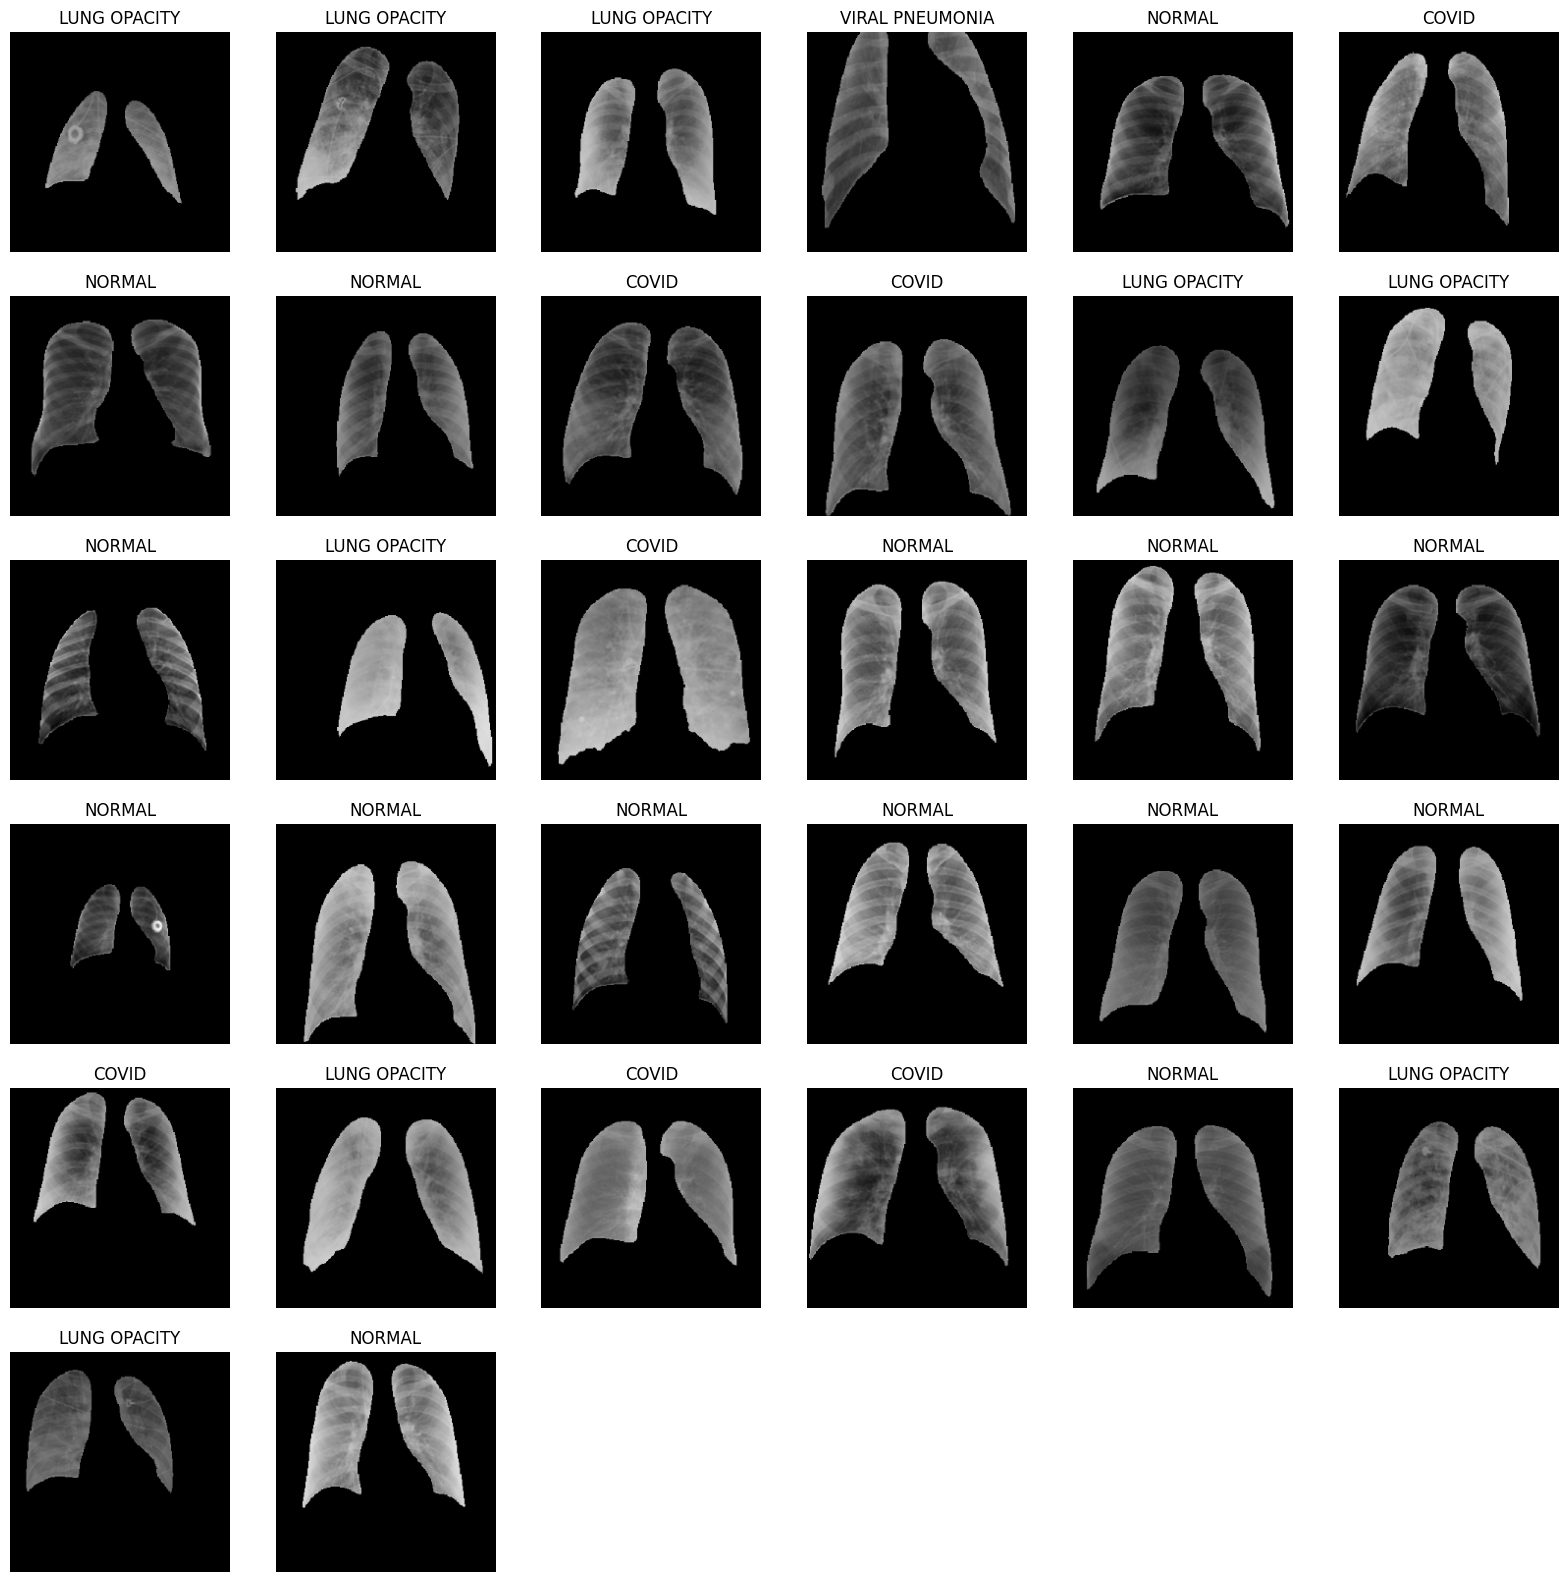

In [5]:
# Visualisation d'un échantillon des données

plt.figure(figsize=(20,20))

class_names = train_ds.class_names

for images, labels in train_ds.take(1):  # Prendre un lot d'images et de labels
    for i, image in enumerate(images):
        plt.subplot(6,6,i+1)
        image = image / 255
        plt.imshow(image)
        label = labels[i].numpy()
        label_name = class_names[label]
        plt.title(label_name)
        plt.axis('off')

plt.show()
    

## Partie 1.4 : preprocessing 

In [8]:
# Optimisation du chargement
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
from tensorflow.keras.applications.vgg19 import preprocess_input

# Normalisation
train_ds = train_ds.map(lambda img, label: (preprocess_input(img), label))
val_ds = val_ds.map(lambda img, label: (preprocess_input(img), label))
test_ds = test_ds.map(lambda img, label: (preprocess_input(img), label))

# Partie 2 : Transfert Learning

In [6]:
# Modèle VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling="max")

# Freezer les couches du VGG16
base_model.trainable = False

# Couche d'entrée
inputs = Input(shape=(224, 224, 3))

# Data augmentation
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)

# Construction du modèle
x = base_model(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
# Comme nous avons des classes déséquilibrées, nous allons utiliser des poids pondérés à la répartition dans le dataset. Pour ça on utilise la fonction
# compute_class_weight

labels = np.concatenate([y.numpy() for _, y in train_ds])

# Calcul des poids des classes
class_labels = np.unique(labels)
class_weight = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weight_dict = dict(enumerate(class_weight))

print("Poids des classes :", class_weight_dict)

Poids des classes : {0: 1.4631870031109575, 1: 0.8802245789145352, 2: 0.5191317144959529, 3: 3.934014869888476}


In [9]:
del labels
del class_labels
del class_weight

In [24]:
# Callbacks
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor="val_loss",
                             min_delta=0.001,
                             patience=3,
                             factor=0.5,
                             cooldown=2,
                             verbose=1)

model_path = get_absolute_path(r"notebooks\AntoineB\artifacts\models\model_tl_vgg19.keras")

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode="min")

In [11]:
history_model = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=100,
                          batch_size=32,
                          verbose=2,
                          class_weight=class_weight_dict,
                          callbacks=[earlystop, reducelr, modelcheckpoint])

Epoch 1/100


530/530 - 1201s - 2s/step - accuracy: 0.5605 - loss: 4.1960 - val_accuracy: 0.6791 - val_loss: 2.8616 - learning_rate: 0.0010
Epoch 2/100
530/530 - 1198s - 2s/step - accuracy: 0.6545 - loss: 2.1835 - val_accuracy: 0.7372 - val_loss: 1.9781 - learning_rate: 0.0010
Epoch 3/100
530/530 - 1193s - 2s/step - accuracy: 0.6752 - loss: 1.6960 - val_accuracy: 0.7075 - val_loss: 1.6905 - learning_rate: 0.0010
Epoch 4/100
530/530 - 1196s - 2s/step - accuracy: 0.6885 - loss: 1.3268 - val_accuracy: 0.7287 - val_loss: 1.2266 - learning_rate: 0.0010
Epoch 5/100
530/530 - 1194s - 2s/step - accuracy: 0.6972 - loss: 1.2035 - val_accuracy: 0.6805 - val_loss: 1.3560 - learning_rate: 0.0010
Epoch 6/100
530/530 - 1194s - 2s/step - accuracy: 0.6875 - loss: 1.1685 - val_accuracy: 0.6725 - val_loss: 1.3344 - learning_rate: 0.0010
Epoch 7/100
530/530 - 1198s - 2s/step - accuracy: 0.6964 - loss: 1.0645 - val_accuracy: 0.6834 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 8/100
530/530 - 1193s - 2s/step - accura

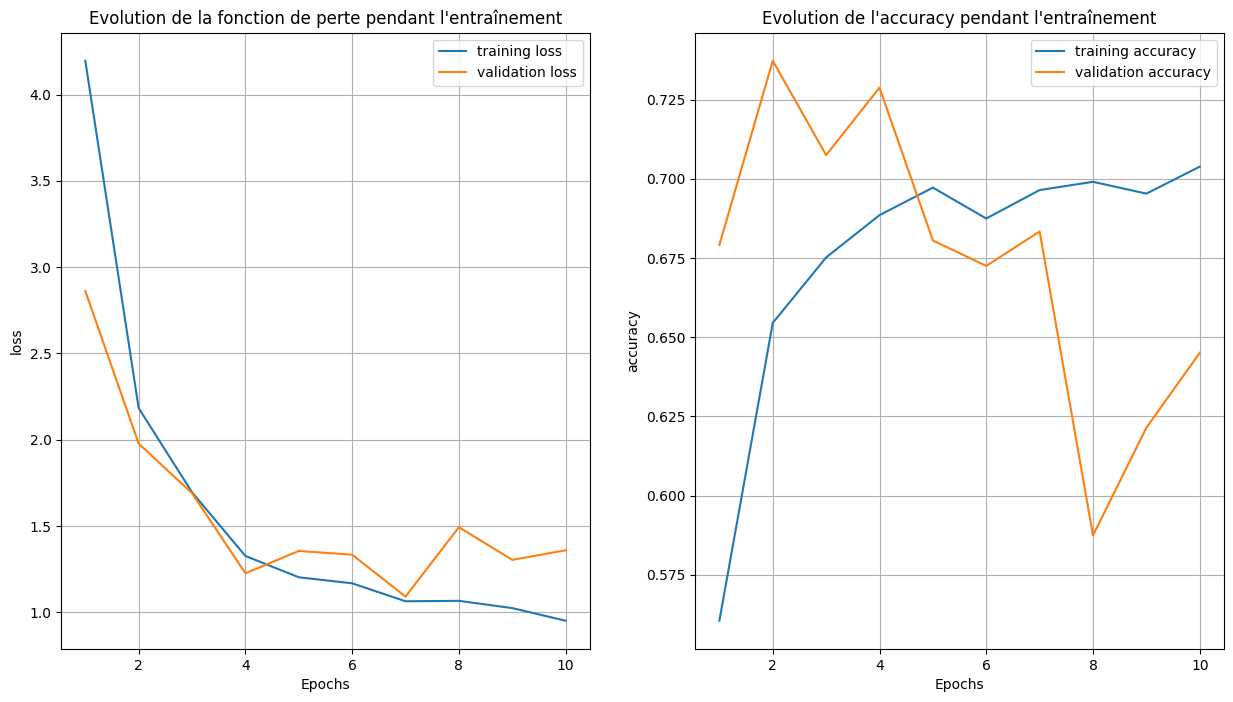

In [14]:

# Visualisation de l'historique de'entraînement
train_loss = history_model.history['loss']
validation_loss = history_model.history['val_loss']

train_acc = history_model.history['accuracy']
validation_acc = history_model.history['val_accuracy']

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(np.arange(1,11,1), train_loss, label='training loss')
plt.plot(np.arange(1,11,1), validation_loss, label='validation loss')
plt.title("Evolution de la fonction de perte pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.legend()
plt.grid('off')

plt.subplot(122)
plt.plot(np.arange(1,11,1), train_acc, label='training accuracy')
plt.plot(np.arange(1,11,1), validation_acc, label='validation accuracy')
plt.title("Evolution de l'accuracy pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.legend()
plt.grid('off')

plt.show()

In [ ]:
# On voit qu'il y a une instabilité dans l'entraînement, et un overfitting à partir de l'étape 4. Nous aalons essayer de relancer
# l'entraînement avec un learning rate moins important, et des couches d'augmentation en plus.

In [20]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

In [16]:
# Modèle VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling="max")

# Freezer les couches du VGG16
base_model.trainable = False

# Couche d'entrée
inputs = Input(shape=(224, 224, 3))

# Data augmentation
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)
x = RandomContrast(0.2)(x)
x = RandomZoom(0.2)(x)

# Construction du modèle
x = base_model(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [21]:
history_model = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=100,
                          batch_size=32,
                          verbose=2,
                          class_weight=class_weight_dict,
                          callbacks=[earlystop, reducelr, modelcheckpoint, tensorboard_callback])

Epoch 1/100
530/530 - 1183s - 2s/step - accuracy: 0.3834 - loss: 4.3072 - val_accuracy: 0.3374 - val_loss: 11.5092 - learning_rate: 1.0000e-04
Epoch 2/100
530/530 - 1120s - 2s/step - accuracy: 0.4803 - loss: 2.7619 - val_accuracy: 0.4055 - val_loss: 8.3456 - learning_rate: 1.0000e-04
Epoch 3/100
530/530 - 1116s - 2s/step - accuracy: 0.5413 - loss: 2.2090 - val_accuracy: 0.4556 - val_loss: 6.4943 - learning_rate: 1.0000e-04
Epoch 4/100
530/530 - 1186s - 2s/step - accuracy: 0.5697 - loss: 1.9645 - val_accuracy: 0.4745 - val_loss: 5.8571 - learning_rate: 1.0000e-04
Epoch 5/100
530/530 - 1147s - 2s/step - accuracy: 0.5836 - loss: 1.7994 - val_accuracy: 0.4924 - val_loss: 5.4213 - learning_rate: 1.0000e-04
Epoch 6/100
530/530 - 1195s - 2s/step - accuracy: 0.6012 - loss: 1.6471 - val_accuracy: 0.5019 - val_loss: 5.0843 - learning_rate: 1.0000e-04
Epoch 7/100
530/530 - 1622s - 3s/step - accuracy: 0.6100 - loss: 1.5422 - val_accuracy: 0.5137 - val_loss: 4.5015 - learning_rate: 1.0000e-04
Epoch

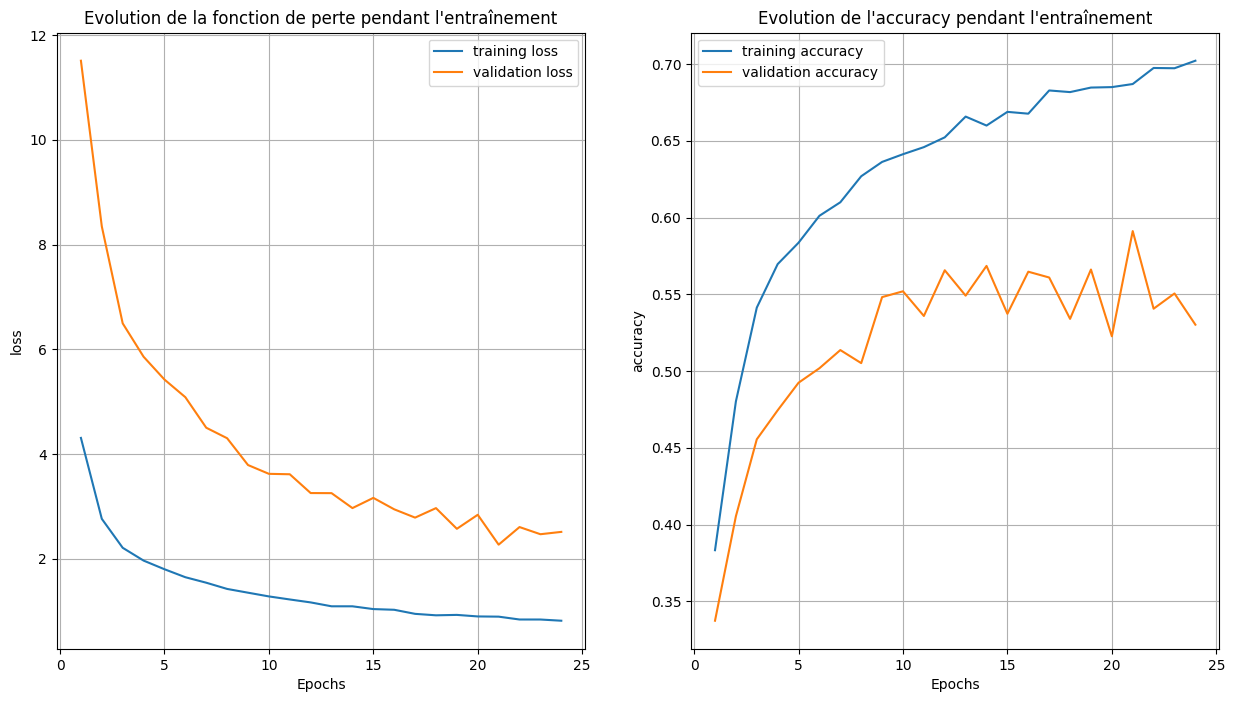

In [23]:

# Visualisation de l'historique de'entraînement
train_loss = history_model.history['loss']
validation_loss = history_model.history['val_loss']

train_acc = history_model.history['accuracy']
validation_acc = history_model.history['val_accuracy']

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(np.arange(1,25,1), train_loss, label='training loss')
plt.plot(np.arange(1,25,1), validation_loss, label='validation loss')
plt.title("Evolution de la fonction de perte pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.legend()
plt.grid('off')

plt.subplot(122)
plt.plot(np.arange(1,25,1), train_acc, label='training accuracy')
plt.plot(np.arange(1,25,1), validation_acc, label='validation accuracy')
plt.title("Evolution de l'accuracy pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.legend()
plt.grid('off')

plt.show()

# L'instabilité est meilleure mais il y a davantage d'overfitting. 

In [25]:
# Modèle VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling="max")

# Freezer les couches du VGG16
base_model.trainable = False

# Couche d'entrée
inputs = Input(shape=(224, 224, 3))

# Data augmentation
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)
x = RandomContrast(0.2)(x)
x = RandomZoom(0.2)(x)

# Construction du modèle
x = base_model(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [26]:
model_path = get_absolute_path(r"notebooks\AntoineB\artifacts\models\model_tl_vgg19_2.keras")

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode="min")

In [27]:
history_model = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=100,
                          batch_size=32,
                          verbose=2,
                          class_weight=class_weight_dict,
                          callbacks=[earlystop, reducelr, modelcheckpoint, tensorboard_callback])

Epoch 1/100
530/530 - 1775s - 3s/step - accuracy: 0.6269 - loss: 1.3955 - val_accuracy: 0.5421 - val_loss: 2.1571 - learning_rate: 0.0010
Epoch 2/100
530/530 - 1784s - 3s/step - accuracy: 0.7006 - loss: 0.7340 - val_accuracy: 0.5477 - val_loss: 1.4899 - learning_rate: 0.0010
Epoch 3/100
530/530 - 1784s - 3s/step - accuracy: 0.7192 - loss: 0.6404 - val_accuracy: 0.5917 - val_loss: 1.4643 - learning_rate: 0.0010
Epoch 4/100
530/530 - 1783s - 3s/step - accuracy: 0.7313 - loss: 0.6005 - val_accuracy: 0.5236 - val_loss: 1.5655 - learning_rate: 0.0010
Epoch 5/100
530/530 - 1782s - 3s/step - accuracy: 0.7430 - loss: 0.5836 - val_accuracy: 0.5784 - val_loss: 1.1952 - learning_rate: 0.0010
Epoch 6/100
530/530 - 1782s - 3s/step - accuracy: 0.7474 - loss: 0.5714 - val_accuracy: 0.6517 - val_loss: 1.2176 - learning_rate: 0.0010
Epoch 7/100
530/530 - 1781s - 3s/step - accuracy: 0.7518 - loss: 0.5564 - val_accuracy: 0.6059 - val_loss: 1.2855 - learning_rate: 0.0010
Epoch 8/100
530/530 - 1783s - 3s/s

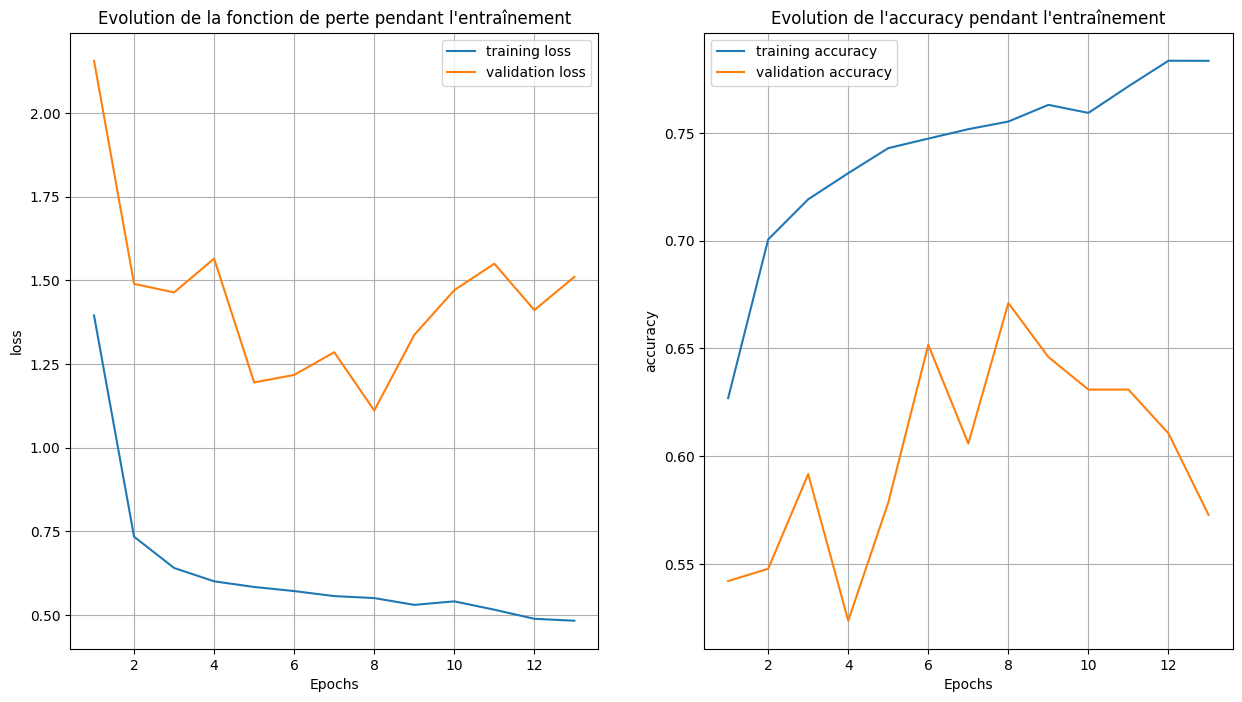

In [29]:

# Visualisation de l'historique de'entraînement
train_loss = history_model.history['loss']
validation_loss = history_model.history['val_loss']

train_acc = history_model.history['accuracy']
validation_acc = history_model.history['val_accuracy']

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(np.arange(1,14,1), train_loss, label='training loss')
plt.plot(np.arange(1,14,1), validation_loss, label='validation loss')
plt.title("Evolution de la fonction de perte pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.legend()
plt.grid('off')

plt.subplot(122)
plt.plot(np.arange(1,14,1), train_acc, label='training accuracy')
plt.plot(np.arange(1,14,1), validation_acc, label='validation accuracy')
plt.title("Evolution de l'accuracy pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.legend()
plt.grid('off')

plt.show()